- [R2RT - Blog](https://r2rt.com/implementing-batch-normalization-in-tensorflow.html)
- [BN Paper](https://arxiv.org/pdf/1502.03167v3.pdf)

In [1]:
%matplotlib inline
from __future__ import print_function
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [2]:
mnist = input_data.read_data_sets("data", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting data/t10k-labels-idx1-ubyte.gz


[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
(784,)


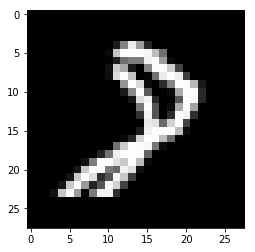

In [3]:
print(mnist.train.labels[3690])
print(mnist.train.images[3690].shape)
plt.imshow(mnist.train.images[3690].reshape((28, 28)), cmap="gray")

In [4]:
def compute_accuracy(y1, y2):
    return 100*((y1 == y2).astype(np.int).sum()/len(y1))

In [5]:
# initial values (fixed, in order to give comparable results)
np.random.seed(3690)

w1_init = np.random.randn(784, 100)
b1_init = np.random.randn(100)

w2_init = np.random.randn(100, 100)
b2_init = np.random.randn(100)

w3_init = np.random.randn(100, 10)
b3_init = np.random.randn(10)

In [8]:
from tensorflow.python.ops.init_ops import glorot_normal_initializer

In [9]:
init = glorot_normal_initializer(seed=3690)

In [10]:
# network without batch normalization
graph_no_bn = tf.Graph()

with graph_no_bn.as_default():
    tf_x_no_bn = tf.placeholder(dtype=tf.float32, 
                                shape=[None, 784])
    tf_y_no_bn = tf.placeholder(dtype=tf.float32, 
                                shape=[None, 10])
    
    # fully connected layer 1 (784 x 100)
    tf_W1_no_bn = tf.Variable(init(shape=[784, 100], dtype=tf.float32),
                              name="W1")
    tf_b1_no_bn = tf.Variable(init(shape=[100], dtype=tf.float32),
                              name="b1")
    tf_z1 = tf.matmul(tf_x_no_bn, tf_W1_no_bn) + tf_b1_no_bn
    tf_l1 = tf.nn.sigmoid(tf_z1)
    
    # fully connected layer 2
    tf_W2_no_bn = tf.Variable(init(shape=[100, 100], dtype=tf.float32), 
                              name="W2")
    tf_b2_no_bn = tf.Variable(init(shape=[100], dtype=tf.float32),
                              name="b2",
                              dtype=tf.float32)
    tf_z2 = tf.matmul(tf_l1, tf_W2_no_bn) + tf_b2_no_bn
    tf_l2 = tf.nn.sigmoid(tf_z2)
    
    # fully connect layer 3
    tf_W3_no_bn = tf.Variable(init(shape=[100, 10], dtype=tf.float32),
                              name="W3")
    tf_b3_no_bn = tf.Variable(init(shape=[10], dtype=tf.float32),
                              name="b3")
    tf_l3 = tf.matmul(tf_l2, tf_W3_no_bn)+tf_b3_no_bn
    
    tf_y_hat_no_bn = tf.nn.softmax(tf_l3)
    predict_y_no_bn = tf.argmax(tf_l3, 1)
    
    cross_entropy_no_bn = -tf.reduce_sum(tf_y_no_bn*tf.log(tf_y_hat_no_bn))
    optimizer_no_bn = tf.train.GradientDescentOptimizer(learning_rate=0.01)
    train_no_nb = optimizer_no_bn.minimize(cross_entropy_no_bn)

In [21]:
batch_size=100
n_iterations = 40000

In [22]:
# SGD
loss_no_bn = []
accuracy_no_bn = []
with tf.Session(graph=graph_no_bn) as sess:
    tf.global_variables_initializer().run()
    for i in range(n_iterations):
        # training
        batch_images, batch_labels = mnist.train.next_batch(batch_size)
        feed_dict = {tf_x_no_bn: batch_images, tf_y_no_bn:batch_labels}
        _ = sess.run(train_no_nb, feed_dict=feed_dict)
        l = sess.run(cross_entropy_no_bn, feed_dict=feed_dict)
        loss_no_bn.append(l)
        if (i+1) % 1000 == 0:
            # prediction
            feed_dict[tf_x_no_bn] = mnist.test.images
            feed_dict[tf_y_no_bn] = mnist.test.labels
            predict_y = sess.run(predict_y_no_bn, feed_dict=feed_dict)
            acc = compute_accuracy(predict_y, np.argmax(mnist.test.labels, axis=1))
            accuracy_no_bn.append(acc)
            print("Iteration {}: {:.4f}, Test Accuracy: {:.2f}%".format(i+1, l, acc))
    train_variagles = [(v.name.split(":")[0], v.eval()) for v in tf.trainable_variables()]

Iteration 1000: 12.921549797058105, Test Accuracy: 94.42%
Iteration 2000: 7.000487327575684, Test Accuracy: 95.82000000000001%
Iteration 3000: 2.3673295974731445, Test Accuracy: 96.89%
Iteration 4000: 2.3273041248321533, Test Accuracy: 97.14%
Iteration 5000: 5.455541133880615, Test Accuracy: 97.63%
Iteration 6000: 0.6532052159309387, Test Accuracy: 97.59%
Iteration 7000: 0.7081977128982544, Test Accuracy: 97.77%
Iteration 8000: 1.7886273860931396, Test Accuracy: 97.89999999999999%
Iteration 9000: 0.14031291007995605, Test Accuracy: 97.84%
Iteration 10000: 0.16038934886455536, Test Accuracy: 97.8%
Iteration 11000: 0.2911721467971802, Test Accuracy: 97.89999999999999%
Iteration 12000: 0.256646066904068, Test Accuracy: 97.98%
Iteration 13000: 0.19726526737213135, Test Accuracy: 98.1%
Iteration 14000: 0.21793484687805176, Test Accuracy: 98.07000000000001%
Iteration 15000: 0.40522676706314087, Test Accuracy: 98.03%
Iteration 16000: 0.16905945539474487, Test Accuracy: 98.08%
Iteration 17000:

In [23]:
print([v[0] for v in train_variagles])
print([v[1].shape for v in train_variagles])

['W1', 'b1', 'W2', 'b2', 'W3', 'b3']
[(784, 100), (100,), (100, 100), (100,), (100, 10), (10,)]


In [24]:
print(tf.contrib.layers.batch_norm.__doc__)

Adds a Batch Normalization layer from http://arxiv.org/abs/1502.03167.

    "Batch Normalization: Accelerating Deep Network Training by Reducing
    Internal Covariate Shift"

    Sergey Ioffe, Christian Szegedy

  Can be used as a normalizer function for conv2d and fully_connected.

  Note: when training, the moving_mean and moving_variance need to be updated.
  By default the update ops are placed in `tf.GraphKeys.UPDATE_OPS`, so they
  need to be added as a dependency to the `train_op`. For example:

  ```python
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      train_op = optimizer.minimize(loss)
  ```

  One can set updates_collections=None to force the updates in place, but that
  can have a speed penalty, especially in distributed settings.

  Args:
    inputs: A tensor with 2 or more dimensions, where the first dimension has
      `batch_size`. The normalization is over all but the last dimension if
      `data_format

In [25]:
init = glorot_normal_initializer(seed=3690)

In [26]:
# Batch Normalized (BN) Neural Network
# Here I use batch normalization layer from tf.contrib.layers.batch_norm
# but it seems like it can not reproduce the results in the blog.
# I'll try tf.nn.batch_normalization in another notebook later.
graph_bn = tf.Graph()

with graph_bn.as_default():
    tf_x_bn = tf.placeholder(dtype=tf.float32, 
                             shape=[None, 784],
                             name="tf_x_bn")
    tf_y_bn = tf.placeholder(dtype=tf.float32, 
                             shape=[None, 10],
                             name="tf_y_bn") 
    tf_is_training = tf.placeholder(tf.bool, name="is_training")
    # layer 1
    tf_W1_bn = tf.Variable(init(shape=[784, 100], dtype=tf.float32),
                           name="W1_bn")
    tf_z1_bn = tf.matmul(tf_x_bn, tf_W1_bn)
    
    # BN for layer 1
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        tf_l1 = tf.contrib.layers.batch_norm(tf_z1_bn,
                                             decay=0.999,
                                             center=True, 
                                             scale=True,
                                             epsilon=0.0001,
                                             activation_fn=tf.nn.sigmoid,
                                             is_training=tf_is_training)
    # layer 2
    tf_W2_bn = tf.Variable(init(shape=[100, 100], dtype=tf.float32),
                           name="W2_bn")
    tf_z2_bn = tf.matmul(tf_l1, tf_W2_bn)
    # BN layer 2
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        tf_l2 = tf.contrib.layers.batch_norm(tf_z2_bn,
                                             decay=0.999,
                                             center=True,
                                             scale=True,
                                             epsilon=0.0001,
                                             activation_fn=tf.nn.sigmoid,
                                             is_training=tf_is_training)
    # layer 3
    tf_W3_bn = tf.Variable(init(shape=[100, 10], dtype=tf.float32),
                           name="W3_bn")
    tf_b3_bn = tf.Variable(init(shape=[10], dtype=tf.float32),
                           name="b3_bn")
    
    tf_z3 = tf.matmul(tf_l2, tf_W3_bn)+tf_b3_bn
    tf_l3 = tf.nn.softmax(tf_z3)
    predict_y_bn = tf.argmax(tf_l3, 1)
    cross_entropy_bn = -tf.reduce_sum(tf_y_bn*tf.log(tf_l3))
    train_op_bn = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(cross_entropy_bn) 

In [27]:
loss_bn = [None for _ in range(n_iterations)]
accuracy_bn = []

with tf.Session(graph=graph_bn) as sess:
    tf.global_variables_initializer().run()
    for i in range(n_iterations):
        # training
        batch_images, batch_labels = mnist.train.next_batch(batch_size)
        feed_dict = {tf_x_bn:batch_images, 
                     tf_y_bn:batch_labels,
                     tf_is_training:True}
        _ = sess.run(train_op_bn, feed_dict=feed_dict)
        l = sess.run(cross_entropy_bn, feed_dict=feed_dict)
        loss_bn[i] = l
        if (i+1) % 1000 == 0:
            # prediction
            feed_dict[tf_x_bn] = mnist.test.images
            feed_dict[tf_y_bn] = mnist.test.labels
            feed_dict[tf_is_training] = False
            predict_y = sess.run(predict_y_bn, feed_dict=feed_dict)
            acc = compute_accuracy(predict_y, np.argmax(mnist.test.labels, axis=1))
            accuracy_bn.append(acc)
            print("Iteration {}:{:.4f}, Test Accuracy:{:.2f}%".format(i+1, l, acc))

Iteration 1000:6.3033, Test Accuracy:70.21%
Iteration 2000:2.2518, Test Accuracy:56.03%
Iteration 3000:1.0217, Test Accuracy:75.30%
Iteration 4000:0.7485, Test Accuracy:71.07%
Iteration 5000:0.5084, Test Accuracy:78.12%
Iteration 6000:0.3757, Test Accuracy:77.00%
Iteration 7000:0.2930, Test Accuracy:77.39%
Iteration 8000:0.4523, Test Accuracy:83.82%
Iteration 9000:0.2309, Test Accuracy:81.81%
Iteration 10000:0.1974, Test Accuracy:83.82%
Iteration 11000:0.1065, Test Accuracy:85.27%
Iteration 12000:0.0743, Test Accuracy:83.60%
Iteration 13000:0.1439, Test Accuracy:85.66%
Iteration 14000:0.0599, Test Accuracy:86.22%
Iteration 15000:0.0836, Test Accuracy:85.20%
Iteration 16000:0.0639, Test Accuracy:86.15%
Iteration 17000:0.1716, Test Accuracy:85.47%
Iteration 18000:0.0478, Test Accuracy:86.34%
Iteration 19000:0.1419, Test Accuracy:86.39%
Iteration 20000:0.0348, Test Accuracy:85.33%
Iteration 21000:0.1298, Test Accuracy:86.13%
Iteration 22000:0.0799, Test Accuracy:85.22%
Iteration 23000:0.0

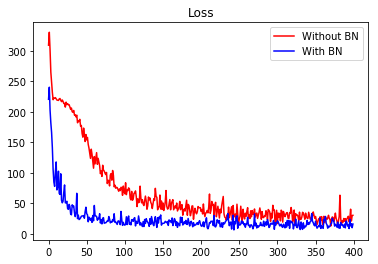

In [28]:
plt.title("Loss")
line_no_bn, = plt.plot(loss_no_bn[:400], "r-")
line_bn, = plt.plot(loss_bn[:400], "b-")
plt.legend([line_no_bn, line_bn], ["Without BN", "With BN"])

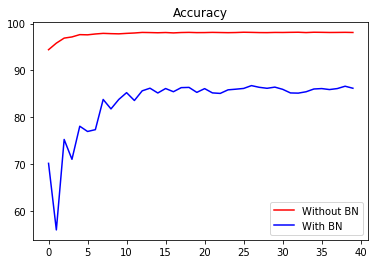

In [29]:
plt.title("Accuracy")
line_no_bn, = plt.plot(accuracy_no_bn, "r-")
line_bn, = plt.plot(accuracy_bn, "b-")
plt.legend([line_no_bn, line_bn], ["Without BN", "With BN"])